In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as pl

def SIFTDetect(gray, frame):
    img = frame
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv2.drawKeypoints(gray,kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return [img, kp, des]

def appendMatches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good

def goodMatchCount(_kpObj, _kpFrame, _obj, _frame, _good):
    src_pts = np.float32([_kpObj[m.queryIdx].pt for m in _good]).reshape(-1,1,2)
    dst_pts = np.float32([_kpFrame[m.trainIdx].pt for m in _good]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = _obj.shape
    pts = np.float32([ [0,0],[0, h-1], [w-1, h-1], [w-1, 0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(_frame, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    return [img2, matchesMask]



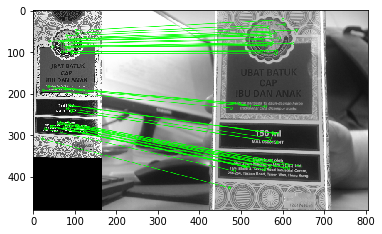

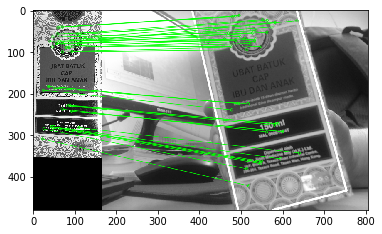

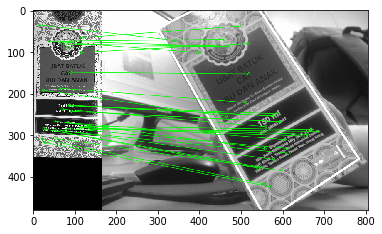

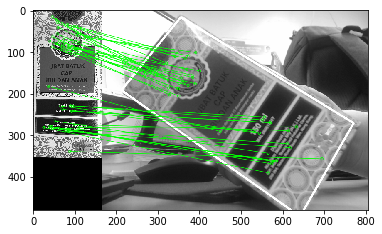

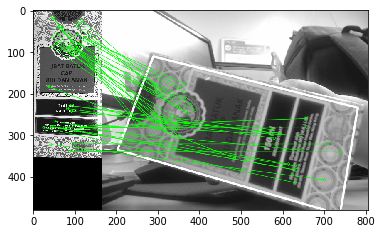

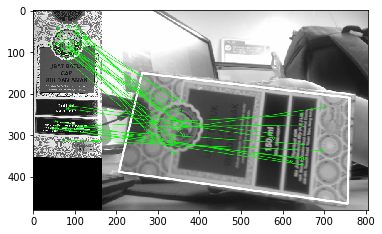

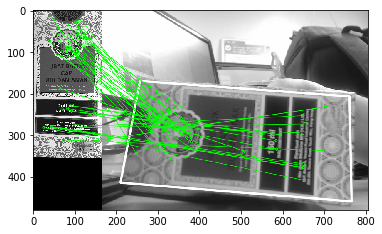

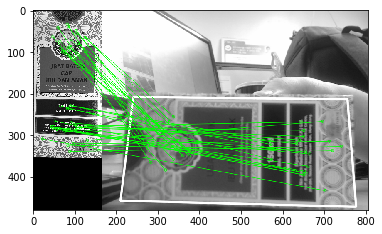

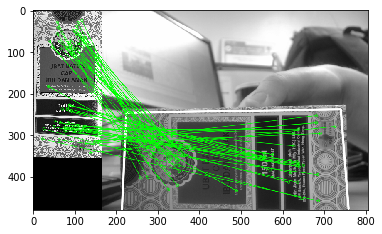

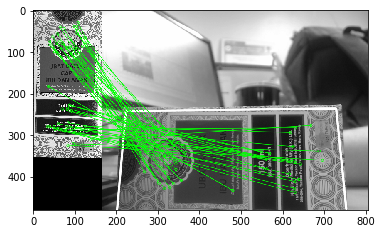

In [12]:
MIN_MATCH_COUNT = 20

cap = cv2.VideoCapture(0)
obj = cv2.imread("img2.jpg")
resizeObj = cv2.resize(obj, (0,0), fx=0.1, fy=0.1)
objGray = cv2.cvtColor(resizeObj, cv2.COLOR_BGR2GRAY)
objSift = SIFTDetect(objGray, resizeObj)
kpObj = objSift[1]
desobj = objSift[2]

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)
flann = cv2.FlannBasedMatcher(index_params, search_params)
i=0
if cap.isOpened():
    while(True):
        ret, frame = cap.read()
       
        if ret:
            grayImg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frameSIFT = SIFTDetect(grayImg, frame)
            matches = flann.knnMatch(desobj, frameSIFT[2],k=2)
            good = appendMatches(matches)
            frame2 = grayImg
            if len(good) > MIN_MATCH_COUNT:
                matchCount = goodMatchCount(kpObj, frameSIFT[1],objGray,grayImg,good)
                draw_params = dict(matchColor = (0, 255, 0),
                                    singlePointColor = None,
                                    matchesMask = matchCount[1],
                                    flags = 2)
                frame2 = cv2.drawMatches(objGray, objSift[1], grayImg, frameSIFT[1], good, None, **draw_params)
            else:
                print("")
            cv2.imshow("SIFT Detect", frame2)
            i+=1
            if(i==15):
                pl.imshow(frame2)
                pl.show()
                i=0
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("frame not available")
            print(video.isOpened())
else:
    print("No Device Captured")
cap.release()
cv2.destroyAllWindows()